In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import cv2 as cv2
import csv
from numpy import genfromtxt
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [2]:
def get_bounding_box(image):
    median_LP = cv2.GaussianBlur(image,(5,5),0)
    CannyEdge_LP = cv2.Canny(median_LP , 200 , 250)

    LP_show_contours = LP.copy()
    _,contours, hierarchy=cv2.findContours(CannyEdge_LP.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(LP_show_contours,(x,y),(x+w,y+h),2)

    # define constrain of bounding box 
    bounding_height_constraint = LP.shape[0] * 0.2
    bounding_width_constraint = LP.shape[1] * 0.05

    # find letter that satisfied the contrain
    bounding_box = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if h / float(w) > 2.5 or h / float(w) < 1.5:
            continue
        if (w >= bounding_width_constraint and h >= bounding_height_constraint):
            bounding_box.append([x-1,y-1,w+1,h+1])
    
    LP_show_box = LP.copy()

    for c in bounding_box:
        x,y,w,h = c
        cv2.rectangle(CannyEdge_LP,(x,y),(x+w,y+h),1)
    #     plt.imshow(CannyEdge_LP, cmap = 'gray')
    #     plt.show()

    # remove the duplicate
    bounding_box.sort()
    bounding_box = [bounding_box[i] for i in range(len(bounding_box)) if i == 0 or bounding_box[i] != bounding_box[i-1]]
    
    return bounding_box , CannyEdge_LP

In [3]:
def feature_engineering(image, bounding_box):
    x,y,w,h = bounding_box
    onpix = 0
    total_x_bar = 0;
    total_y_bar = 0;
    for i in range(x+w):
        for j in range(y+h):
            if (image[j][i] == 255):
                onpix = onpix + 1;
                total_x_bar = total_x_bar + (i - x);
                total_y_bar = total_y_bar + (j - y);
    
    total_x_variance = 0;
    total_y_variance = 0;
    for i in range(x+w):
        for j in range(y+h):
            if (image[j][i] == 255):
                total_x_variance = total_x_variance + ( ((i - x) - total_x_bar) * ((i - x) - total_x_bar) )
                total_y_variance = total_y_variance + ( ((j - y) - total_y_bar) * ((j - y) - total_y_bar) )
    
    
    x_bar = total_x_bar / onpix
    y_bar = total_y_bar / onpix
    x2bar = total_x_variance / onpix
    y2bar = total_y_variance / onpix
                
    return (onpix , x_bar , y_bar , x2bar , y2bar)

In [4]:
# Get X and y 

# train = pd.read_csv("train.csv")
# y = train["letter"]
# del train["letter"]
# X = train

In [5]:
# training SVM model 

# clf = Pipeline([
#   ('normalization', MinMaxScaler(feature_range = (0,1))),
#   ('GaussianNB', GaussianNB())
# ])

# clf.fit(X, y)

In [6]:
# bounding_box , CannyEdge_LP = get_bounding_box('output.png')
# (onpix , x_bar , y_bar , x2ybr , xy2br) = feature_engineering(CannyEdge_LP , bounding_box[3])
# test_list = list((onpix , x_bar , y_bar , x2ybr , xy2br))
# test = []
# test.append(test_list)
# clf.predict(test)

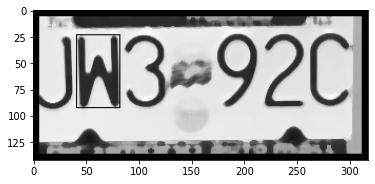

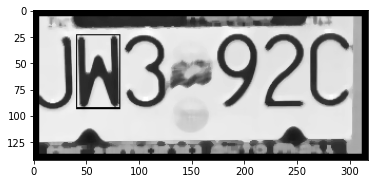

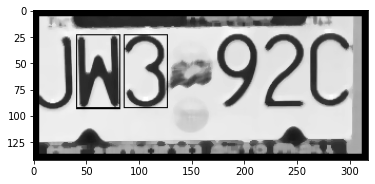

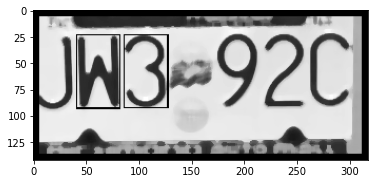

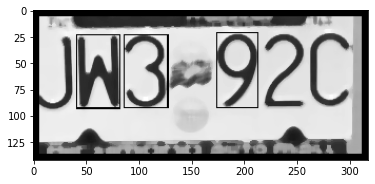

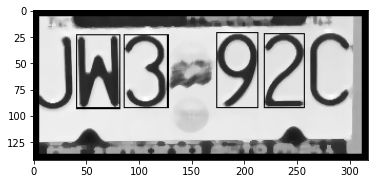

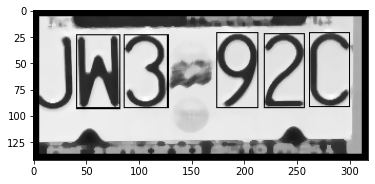

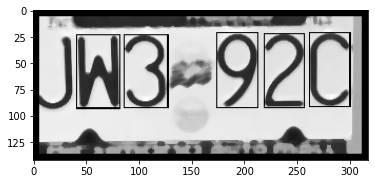

[[41, 23, 41, 69],
 [41, 23, 41, 70],
 [86, 23, 41, 69],
 [86, 23, 42, 69],
 [174, 21, 39, 71],
 [219, 22, 38, 70],
 [262, 21, 38, 70],
 [262, 21, 39, 70]]

In [7]:
LP = cv2.imread('output.png',0)
bounding_box , CannyEdge_LP = get_bounding_box(LP)
for c in bounding_box:
    x,y,w,h = c
    cv2.rectangle(LP,(x,y),(x+w,y+h),1)
    plt.imshow(LP, cmap = 'gray')
    plt.show()
bounding_box

In [13]:
# x,y,w,h = bounding_box[0]
# letter = LP[y:y+h,x:x+w]
# plt.imshow(letter, cmap = 'gray')
# plt.show()
# cv2.imwrite("H.png", letter)

In [9]:
# SIFT for OCR

# Cite: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
def match_letters(LP, letter):
#     MIN_MATCH_COUNT = 3

    img1 = LP               # queryImage
    img2 = letter           # trainImage

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

#     if len(good) > MIN_MATCH_COUNT:
#         return True
#     else:
#         return False
    return len(good)

In [10]:
base_images = ["A" , "B" , "C" , "D" , "E" , "F" , "G" , "H" ,  "I" , "J" , "K" , "L" , "M" , "N" , "O" , "P" , "Q",
              "R" , "S" , "T", "U" , "V" , "W" , "X" , "Y" , "Z" , "0" , "1" , "2" , "3" , "4" , "5" , "6" , "7" ,
              "8" , "9"]
LP_recognize = []
index = 0
LP = cv2.imread('output.png',0)
bounding_box , CannyEdge_LP = get_bounding_box(LP)

for i in range(len(bounding_box)):
    match_max = 0
    x,y,w,h = bounding_box[i]
    extracted_letter = LP[y:y+h,x:x+w]
#     plt.imshow(extracted_letter, cmap = 'gray')
#     plt.show()
    for j in range(len(base_images)):
        letter_path = "base_images/" + base_images[j] + ".png"
        letters = cv2.imread(letter_path , 0)
#         plt.imshow(letters, cmap = 'gray')
#         plt.show()
        len_good = match_letters(extracted_letter , letters)
        if len_good > match_max:
            match_max = len_good
            index = j
    print(match_max)
    LP_recognize.append(base_images[index])
print(LP_recognize)

4
4
7
5
3
4
2
2
['K', 'K', '3', '3', '2', '7', 'Y', 'Y']


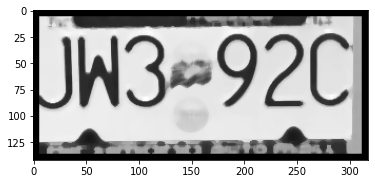

In [11]:
plt.imshow(LP, cmap = 'gray')
plt.show()

not match
0


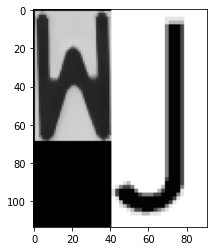

(<matplotlib.image.AxesImage at 0x12ebc2150>, None)

In [12]:
# Just for report picture

LP = cv2.imread('output.png',0)
img1 = letter                                   # queryImage
img2 = cv2.imread('base_images/J.png',0)         # trainImage

MIN_MATCH_COUNT = 4

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    hw = img1.shape
    h = hw[0]
    w = hw[1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    img2 = cv2.polylines(img2,[np.int32(pts)],True,255,3, cv2.LINE_AA)
    print("match")


else:
    print("not match")
    matchesMask = None

print(len(good))
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()